In [14]:
%matplotlib inline
import numpy as np
import pymc3 as pm
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
import arviz as az
import seaborn as sns
sns.set(rc={'figure.figsize':(12,8)})
sns.set_theme()

from IPython.display import display, Markdown
az.style.use('arviz-darkgrid')
np.random.seed(44)

In [15]:
plt.rcParams['font.size'] = 11
plt.rcParams['legend.fontsize'] = 'small'
plt.rcParams.update({
    "figure.figsize": [8, 4],
    'figure.constrained_layout.use': True,
    'font.size': 11.0,
    'hist.bins': 'auto',
    'lines.linewidth': 3.0,
    'lines.markeredgewidth': 2.0,
    'lines.markerfacecolor': 'none',
    'lines.markersize': 8.0, 
})

In [16]:
df = load_data(r"/Users/christian/supsi/6th sem/bayesian_retry/data_hockey")
df = df.loc[df.Resultat != " -:-"].reset_index(drop=True)
df

,Tag,Datum,Zeit,Home,Away,Resultat,Drittel,OT/SO,Status,Versch.,Stadion,Zus.,TV/Online,Id,Liga,Region,Phase
0,Di,07.09.2021,19:45,HC Ajoie,EHC Biel-Bienne,1:3,0:0|1:2|0:1,NaN,Ende,False,"Raiffeisen Arena, 2900 Porrentruy JU",3325,MYSPORTS,20221105000001,NL,CH,Regular Season
1,Di,07.09.2021,19:45,SC Bern,Fribourg-Gottéron,3:6,0:2|2:0|1:4,NaN,Ende,False,"PostFinance-Arena, 3014 Bern BE",12700,MYSPORTS,20221105000002,NL,CH,Regular Season
2,Di,07.09.2021,19:45,ZSC Lions,Genève-Servette HC,4:2,0:0|3:0|1:2,NaN,Ende,False,"Hallenstadion, 8050 Zürich ZH",6882,MYSPORTS,20221105000003,NL,CH,Regular Season
3,Di,07.09.2021,19:45,EV Zug,HC Davos,5:2,2:0|0:0|3:2,NaN,Ende,False,"BOSSARD Arena, 6303 Zug",6427,MYSPORTS,20221105000006,NL,CH,Regular Season
4,Mi,08.09.2021,19:45,HC Lugano,SC Rapperswil-Jona Lakers,2:0,1:0|0:0|1:0,NaN,Ende,False,"Cornèr Arena, 6948 Porza Ti",4872,MYSPORTS,20221105000005,NL,CH,Regular Season
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2445,Do,29.04.2021,20:00,ZSC Lions,Genève-Servette HC,1:4,1:1|0:1|0:2,NaN,Ende,False,"Hallenstadion, 8050 Zürich ZH",50,"SRF,RTS,RSI,MYSPORTS",20211105000354,NL,CH,Playoff 1/2 Final
2446,Sa,01.05.2021,20:00,SC Rapperswil-Jona Lakers,EV Zug,3:6,0:3|2:1|1:2,NaN,Ende,False,"St.Galler Kantonalbank Arena, 8640 Rapperswil SG",50,"SRF,RTS,RSI,MYSPORTS",20211105000355,NL,CH,Playoff 1/2 Final
2447,Mo,03.05.2021,20:00,EV Zug,Genève-Servette HC,1:0,0:0|1:0|0:0,NaN,Ende,False,"BOSSARD Arena, 6303 Zug",50,"SRF,RTS,RSI,MYSPORTS",20211105000359,NL,CH,Playoff Final
2448,Mi,05.05.2021,19:00,Genève-Servette HC,EV Zug,1:2,0:0|1:1|0:1,NaN,Ende,False,"Les Vernets, 1227 Les Acacias GE",50,"SRF,RTS,RSI,MYSPORTS",20211105000360,NL,CH,Playoff Final


# Preprocessing and data exploration

In [17]:
# create a dictionary to store the points for each team
points_dict = {}
hcl_home = []
hcl_away = []

# iterate over each row in the dataframe
for index, row in df.iterrows():
    # extract the team names
    home_team = row['Home']
    away_team = row['Away']
    
    # extract the result for the home and away team
    home_result = row['Resultat'].split(':')[0].strip()
    away_result = row['Resultat'].split(':')[1].strip()
    
    # add points to the home team
    if home_team not in points_dict:
        points_dict[home_team] = {'total': 0, 'home': 0, 'away': 0}
    # add to total points column
    points_dict[home_team]['total'] += int(home_result)
    points_dict[home_team]['home'] += int(home_result)

    # add to list of hcl points
    if home_team == 'HC Lugano':
        hcl_home.append(home_result)
    # add to specific team column
    points_dict[home_team][away_team + ' (away)'] = points_dict[home_team].get(away_team + ' (away)', 0) + int(away_result)
    
    # add points to the away team
    if away_team not in points_dict:
        points_dict[away_team] = {'total': 0, 'home': 0, 'away': 0}
    points_dict[away_team]['total'] += int(away_result)
    points_dict[away_team]['away'] += int(away_result)

    # add to list of hcl points
    if away_team == 'HC Lugano':
        hcl_away.append(away_result)

    points_dict[away_team][home_team + ' (home)'] = points_dict[away_team].get(home_team + ' (home)', 0) + int(home_result)

# create a new dataframe from the points_dict
points_df = pd.DataFrame.from_dict(points_dict, orient='index')

In [18]:
points_df

,total,home,away,EHC Biel-Bienne (away),HC Lugano (away),ZSC Lions (home),HC Ambri-Piotta (away),SC Bern (home),EV Zug (home),Genève-Servette HC (away),...,Genève-Servette HC (home),EHC Biel-Bienne (home),SC Rapperswil-Jona Lakers (away),Lausanne HC (home),HC Ajoie (home),HC Ajoie (away),EHC Kloten (home),EHC Kloten (away),SC Langenthal (away),SC Langenthal (home)
HC Ajoie,89,53,36,7.0,14.0,13.0,4.0,8.0,13.0,7.0,...,7.0,11.0,12.0,7.0,NaN,NaN,NaN,NaN,NaN,NaN
EHC Biel-Bienne,1151,631,520,NaN,48.0,59.0,33.0,65.0,57.0,42.0,...,48.0,NaN,12.0,51.0,2.0,1.0,20.0,19.0,NaN,NaN
SC Bern,1223,656,567,52.0,42.0,54.0,31.0,NaN,70.0,52.0,...,63.0,64.0,15.0,53.0,3.0,1.0,14.0,21.0,NaN,NaN
Fribourg-Gottéron,1086,604,482,37.0,44.0,56.0,32.0,52.0,44.0,77.0,...,80.0,42.0,19.0,82.0,1.0,4.0,12.0,17.0,NaN,NaN
ZSC Lions,1258,668,590,45.0,42.0,NaN,32.0,59.0,71.0,44.0,...,46.0,60.0,21.0,50.0,8.0,4.0,24.0,23.0,NaN,NaN
Genève-Servette HC,1118,606,512,42.0,48.0,44.0,41.0,82.0,61.0,NaN,...,NaN,67.0,14.0,60.0,7.0,5.0,13.0,16.0,NaN,NaN
EV Zug,1351,737,614,42.0,57.0,64.0,45.0,75.0,NaN,30.0,...,39.0,39.0,19.0,48.0,3.0,3.0,15.0,17.0,NaN,NaN
HC Davos,1212,624,588,48.0,50.0,57.0,56.0,46.0,77.0,41.0,...,45.0,54.0,42.0,50.0,6.0,0.0,29.0,19.0,NaN,NaN
HC Lugano,1233,691,542,48.0,NaN,77.0,52.0,51.0,91.0,50.0,...,56.0,71.0,28.0,41.0,5.0,2.0,26.0,18.0,NaN,NaN
SC Rapperswil-Jona Lakers,618,351,267,30.0,31.0,42.0,23.0,26.0,35.0,18.0,...,29.0,20.0,NaN,29.0,5.0,5.0,9.0,5.0,NaN,NaN


In [19]:
# select HC Lugano, HC Ambri-Piotta for our first hypotheses test.
df_1 = points_df[points_df.index.isin(['HC Lugano', 'HC Ambri-Piotta'])]
df_1

,total,home,away,EHC Biel-Bienne (away),HC Lugano (away),ZSC Lions (home),HC Ambri-Piotta (away),SC Bern (home),EV Zug (home),Genève-Servette HC (away),...,Genève-Servette HC (home),EHC Biel-Bienne (home),SC Rapperswil-Jona Lakers (away),Lausanne HC (home),HC Ajoie (home),HC Ajoie (away),EHC Kloten (home),EHC Kloten (away),SC Langenthal (away),SC Langenthal (home)
HC Lugano,1233,691,542,48.0,NaN,77.0,52.0,51.0,91.0,50.0,...,56.0,71.0,28.0,41.0,5.0,2.0,26.0,18.0,NaN,NaN
HC Ambri-Piotta,992,536,456,43.0,55.0,51.0,NaN,47.0,80.0,32.0,...,53.0,68.0,30.0,57.0,5.0,2.0,29.0,27.0,3.0,1.0


# Hypothesis test 1
We want to compare if HC Lugano scores more goals while playing at home or away.

In [20]:
# cast to float numpy arrays for pymc3
points_home = df_1.iloc[0, 3:].values
points_away = df_1.iloc[1, 3:].values
points_home = np.array(points_home, dtype=float)
points_away = np.array(points_away, dtype=float)

In [21]:
hcl_home, hcl_away = np.array(sorted(hcl_home), dtype=float), np.array(sorted(hcl_away), dtype=float)

<AxesSubplot: xlabel='goals', ylabel='Count'>

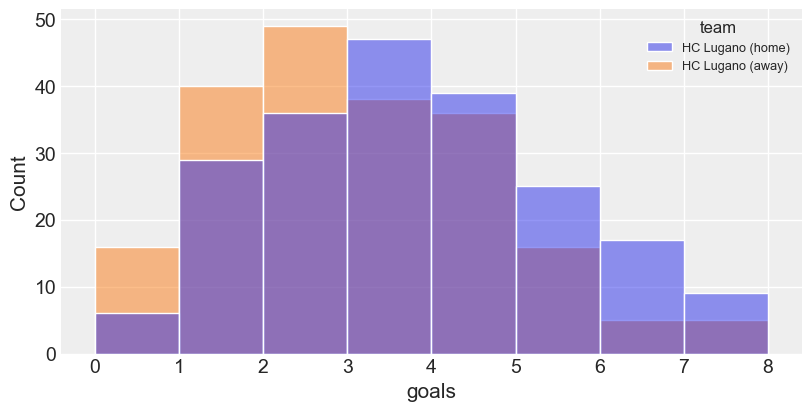

In [22]:
y  = pd.DataFrame(dict(goals=np.r_[hcl_home, hcl_away], team=np.r_[["HC Lugano (home)"]*len(hcl_home), ['HC Lugano (away)']*len(hcl_away)]))
sns.histplot(data=y, x="goals", hue="team", bins=8)

In [23]:
print(f"Sample mean goals at home: {np.mean(hcl_home):.3f}")
print(f"Sample mean goals away: {np.mean(hcl_away):.3f}")

Sample mean goals at home: 3.322
Sample mean goals away: 2.644


# Research question
From the distributions we see that when the game is played at home the mean goals are higher.

We want to test if this is true:
* Are the expected goals for the home team higher than the ones away?

We assume the distribution is Normal.

# Setup

* We have two samples, from which we can compute:

    * observed means, also known as sample means: ($\bar{y}_{home}$, $\bar{y}_{away}$) 

    * sample standard deviations ($s_{home}, s_{away}$) 

    * numerosity ($n_{home}, n_{away}$)


* The sample are drawn from two populations with unknown parameters $\mu_{home}, \mu_{away}, \sigma_{home}, \sigma_{away}$.

# Background information to set the prior
From a research we found the mean goals per game is 7.2. Given this we can divide the score between the two teams, resulting in a mean of 3.6 goals per team in one game.

Extreme values of goals are 0 and 8. A plausible value of standard deviation in the population is thus   (3.6 - 0)/2 = 1.8.

We know that:
$$
\frac{alpha}{beta} = mu
$$
$$
\frac{alpha}{beta^2} = sigma^2
$$

therefore we can calculate alpha and beta as:
$$
alpha = \frac{mu^2}{sigma^2}
$$
$$
beta = \frac{mu}{sigma^2}
$$

In [81]:
mu = 3.6
sigma = 1.8

alpha = mu**2 / sigma**2
beta = mu / sigma**2
alpha, beta

(4.0, 1.1111111111111112)

# Prior for $\mu_{\text{home}}$ and $\mu_{\text{away}}$

* The  mean goals of the population lies in (1.8, 5.4);  we interpret this as an interval of $\pm 2 \sigma$ around the mean. Thus:

$$
\mu_{\text{home}}   \sim  Gam(4, 1.1)
$$
$$
\mu_{\text{away}}   \sim  Gam(4, 1.1)
$$

* We assign the same priors to both groups, so that we are not favoring a group over another a priori.



In [24]:
# Here we tune the half-normal prior for sigma, adjusting the scale to have the median close to 1.8
# this yields a  diffuse prior, but still defined over plausible range.
pd.DataFrame(halfnorm.rvs(scale=3, size=10000)).describe()

,0
count,10000.000000
mean,2.408994
std,1.814548
min,0.000498
25%,0.980877
50%,2.040138
75%,3.451943
max,11.478192


#  The probabilistic model

* We assume the two population to have different $\sigma$ (often  the same $\sigma$ is assumed for both populations).
$$
\mu_{\text{home}}\sim Gam(4,1.1) 
$$
$$
\vec{y}_{\text{home}} \sim Po(\mu_{\text{home}})
$$
$$
\mu_{\text{away}} \sim Gam(4,1.1)
$$
$$
\vec{y}_{\text{away}} \sim Po(\mu_{\text{away}})
$$

# Comparing the two means

In [71]:
with pm.Model() as model:
    #prior
    mu_home = pm.Gamma('mu_home', alpha, beta)
    mu_away = pm.Gamma('mu_away', alpha, beta)

    #likelihood of group 1
    y_home = pm.Poisson('y_1', mu=mu_home, observed= hcl_home)

    #likelihood of group 2
    y_away = pm.Poisson('y_2', mu=mu_away, observed= hcl_away)

    #The deterministic variables are function of the parameters, whose values appear in the trace.
    diff_of_means = pm.Deterministic('diff_of_means', mu_home - mu_away)

In [72]:
with model:
    trace = pm.sample(return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_away, mu_home]
WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: No module named 'mkl'
WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: No module named 'mkl'
WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: No module named 'mkl'
WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: No module named 'mkl'


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 8 seconds.


array([[<AxesSubplot: title={'center': 'mu_home'}>,
        <AxesSubplot: title={'center': 'mu_home'}>],
       [<AxesSubplot: title={'center': 'mu_away'}>,
        <AxesSubplot: title={'center': 'mu_away'}>],
       [<AxesSubplot: title={'center': 'diff_of_means'}>,
        <AxesSubplot: title={'center': 'diff_of_means'}>]], dtype=object)

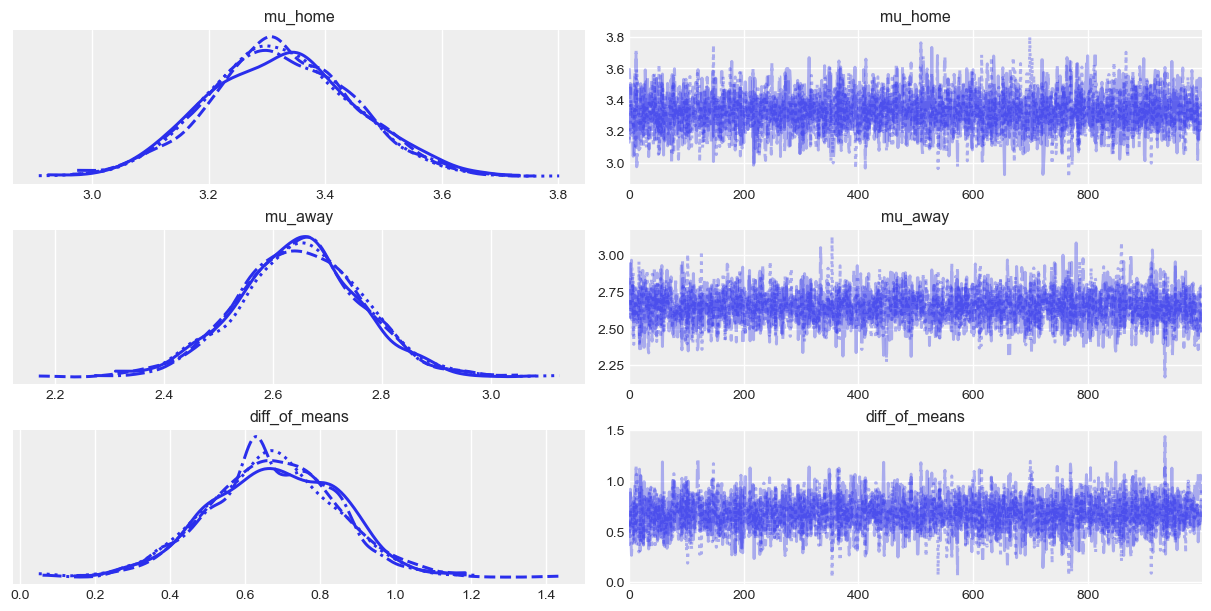

In [73]:
az.plot_trace(trace)

It converges well

In [74]:
az.summary(trace, hdi_prob=0.95)

,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu_home,3.324,0.125,3.088,3.574,0.002,0.002,3415.0,2798.0,1.0
mu_away,2.650,0.112,2.423,2.859,0.002,0.001,3128.0,2792.0,1.0
diff_of_means,0.675,0.168,0.355,1.004,0.003,0.002,3368.0,3009.0,1.0


<AxesSubplot: title={'center': 'diff_of_means'}>

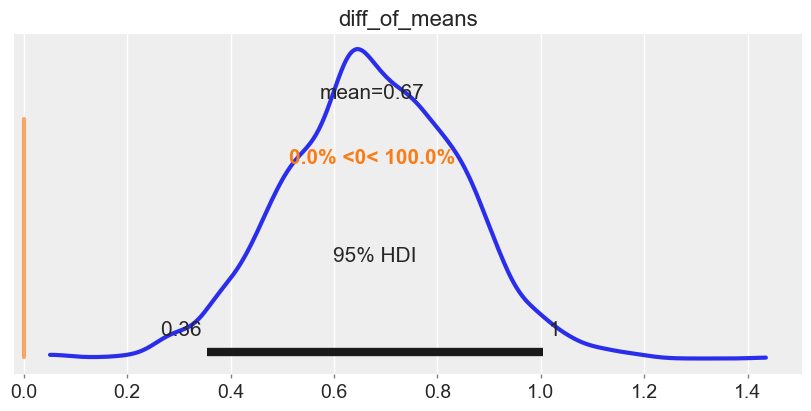

In [75]:
az.plot_posterior(trace,  var_names="diff_of_means", ref_val=0, hdi_prob=0.95)

<AxesSubplot: title={'center': 'diff_of_means'}>

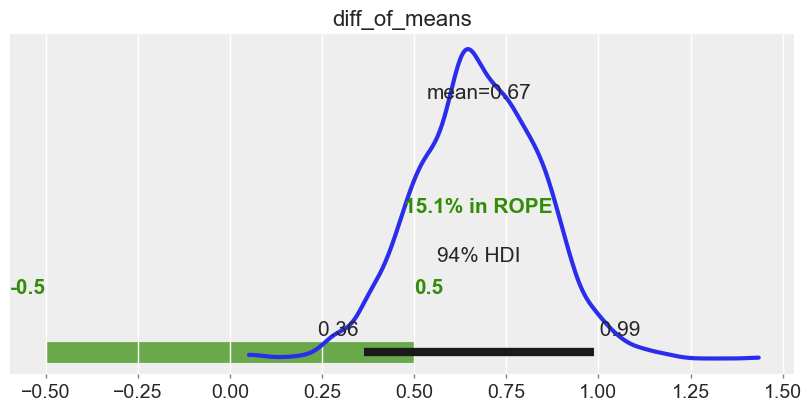

In [76]:
az.plot_posterior(trace,  var_names="diff_of_means", rope=[-0.5,0.5])

In [77]:
samples = az.extract_dataset(trace,)
diff_samples = samples.diff_of_means.values
p_significant_positive =  ((diff_samples > 0.5).sum()) / len(diff_samples)
p_significant_negative = ((diff_samples < -0.5).sum()) / len(diff_samples)
p_practically_eq = 1 -  p_significant_negative  -  p_significant_positive

print("p_significant_positive: ", "%.3f" % p_significant_positive)
print("p_practically_eq: ", "%.3f" % p_practically_eq)
print("p_significant_negative: ", "%.3f" % p_significant_negative)

p_significant_positive:  0.849
p_practically_eq:  0.151
p_significant_negative:  0.000


# Posterior predictive checks

array([<AxesSubplot: xlabel='y_1 / y_1'>,
       <AxesSubplot: xlabel='y_2 / y_2'>], dtype=object)

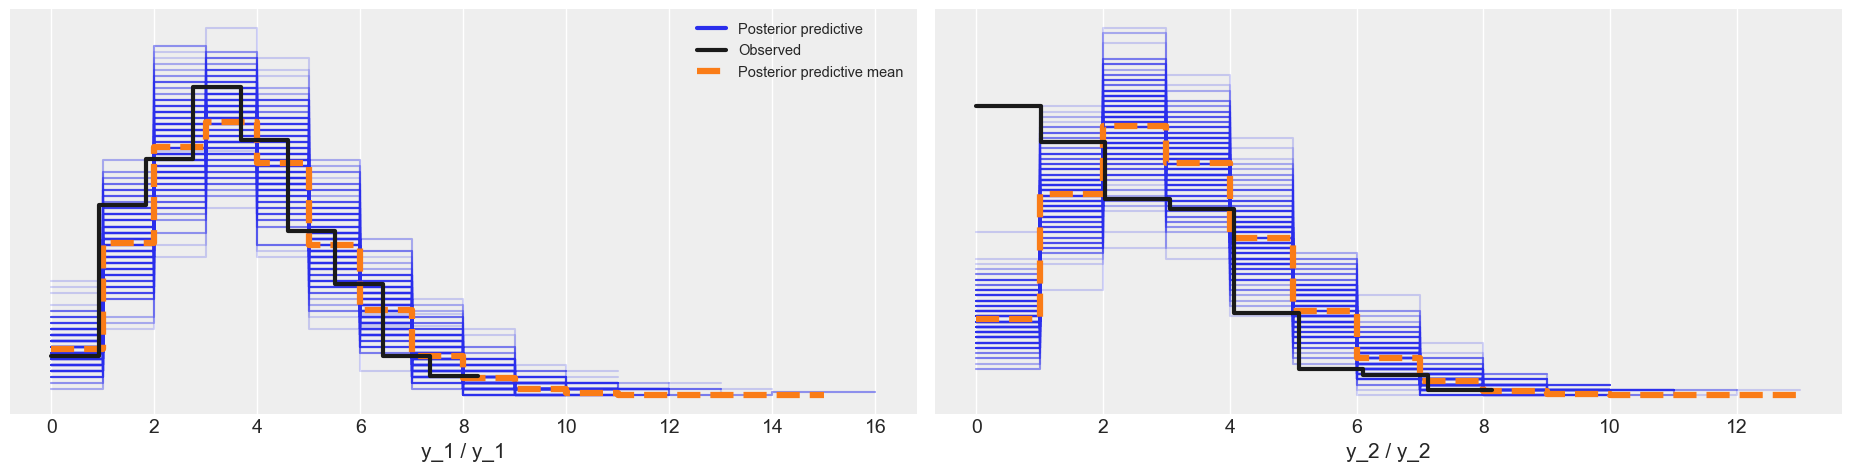

In [80]:
# Quiz yourself: write a pseudo code explaining what the code below does.
with model:
     ppc = pm.sample_posterior_predictive(trace, samples=300)
    
# The density is too low in the bulk of the distribution, for both groups. 
az.plot_ppc(az.from_pymc3(posterior_predictive=ppc, model=model))

# hyp 2


In [25]:
df

,Tag,Datum,Zeit,Home,Away,Resultat,Drittel,OT/SO,Status,Versch.,Stadion,Zus.,TV/Online,Id,Liga,Region,Phase
0,Di,07.09.2021,19:45,HC Ajoie,EHC Biel-Bienne,1:3,0:0|1:2|0:1,NaN,Ende,False,"Raiffeisen Arena, 2900 Porrentruy JU",3325,MYSPORTS,20221105000001,NL,CH,Regular Season
1,Di,07.09.2021,19:45,SC Bern,Fribourg-Gottéron,3:6,0:2|2:0|1:4,NaN,Ende,False,"PostFinance-Arena, 3014 Bern BE",12700,MYSPORTS,20221105000002,NL,CH,Regular Season
2,Di,07.09.2021,19:45,ZSC Lions,Genève-Servette HC,4:2,0:0|3:0|1:2,NaN,Ende,False,"Hallenstadion, 8050 Zürich ZH",6882,MYSPORTS,20221105000003,NL,CH,Regular Season
3,Di,07.09.2021,19:45,EV Zug,HC Davos,5:2,2:0|0:0|3:2,NaN,Ende,False,"BOSSARD Arena, 6303 Zug",6427,MYSPORTS,20221105000006,NL,CH,Regular Season
4,Mi,08.09.2021,19:45,HC Lugano,SC Rapperswil-Jona Lakers,2:0,1:0|0:0|1:0,NaN,Ende,False,"Cornèr Arena, 6948 Porza Ti",4872,MYSPORTS,20221105000005,NL,CH,Regular Season
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2445,Do,29.04.2021,20:00,ZSC Lions,Genève-Servette HC,1:4,1:1|0:1|0:2,NaN,Ende,False,"Hallenstadion, 8050 Zürich ZH",50,"SRF,RTS,RSI,MYSPORTS",20211105000354,NL,CH,Playoff 1/2 Final
2446,Sa,01.05.2021,20:00,SC Rapperswil-Jona Lakers,EV Zug,3:6,0:3|2:1|1:2,NaN,Ende,False,"St.Galler Kantonalbank Arena, 8640 Rapperswil SG",50,"SRF,RTS,RSI,MYSPORTS",20211105000355,NL,CH,Playoff 1/2 Final
2447,Mo,03.05.2021,20:00,EV Zug,Genève-Servette HC,1:0,0:0|1:0|0:0,NaN,Ende,False,"BOSSARD Arena, 6303 Zug",50,"SRF,RTS,RSI,MYSPORTS",20211105000359,NL,CH,Playoff Final
2448,Mi,05.05.2021,19:00,Genève-Servette HC,EV Zug,1:2,0:0|1:1|0:1,NaN,Ende,False,"Les Vernets, 1227 Les Acacias GE",50,"SRF,RTS,RSI,MYSPORTS",20211105000360,NL,CH,Playoff Final


In [26]:
df.Resultat = df.Resultat.apply(lambda x: x.split(':')[0].strip() + ':' + x.split(':')[1].strip())

In [27]:
df.Resultat.unique()

array(['1:3', '3:6', '4:2', '5:2', '2:0', '3:2', '3:1', '1:4', '1:2',
       '3:4', '6:2', '4:6', '4:5', '5:4', '2:7', '4:3', '8:1', '5:3',
       '2:1', '3:5', '4:0', '3:0', '5:1', '2:6', '0:3', '6:0', '2:5',
       '2:3', '1:0', '4:1', '6:3', '4:10', '0:1', '1:5', '2:4', '9:3',
       '0:5', '7:5', '0:2', '6:5', '8:0', '6:1', '4:8', '8:2', '1:6',
       '5:6', '7:0', '6:4', '0:0', '8:7', '5:0', '3:7', '0:4', '7:3',
       '11:0', '4:7', '8:4', '7:2', '1:9', '7:1', '0:6', '7:4', '0:7',
       '9:4', '1:8', '8:3', '1:7', '9:2', '10:3', '8:5', '6:9', '5:7',
       '7:6', '6:7', '4:9', '3:9', '3:8'], dtype=object)

In [28]:
df.drop(df[df.Resultat == '0:0'].index, inplace=True)

In [29]:
df.head()

,Tag,Datum,Zeit,Home,Away,Resultat,Drittel,OT/SO,Status,Versch.,Stadion,Zus.,TV/Online,Id,Liga,Region,Phase
0,Di,07.09.2021,19:45,HC Ajoie,EHC Biel-Bienne,1:3,0:0|1:2|0:1,NaN,Ende,False,"Raiffeisen Arena, 2900 Porrentruy JU",3325,MYSPORTS,20221105000001,NL,CH,Regular Season
1,Di,07.09.2021,19:45,SC Bern,Fribourg-Gottéron,3:6,0:2|2:0|1:4,NaN,Ende,False,"PostFinance-Arena, 3014 Bern BE",12700,MYSPORTS,20221105000002,NL,CH,Regular Season
2,Di,07.09.2021,19:45,ZSC Lions,Genève-Servette HC,4:2,0:0|3:0|1:2,NaN,Ende,False,"Hallenstadion, 8050 Zürich ZH",6882,MYSPORTS,20221105000003,NL,CH,Regular Season
3,Di,07.09.2021,19:45,EV Zug,HC Davos,5:2,2:0|0:0|3:2,NaN,Ende,False,"BOSSARD Arena, 6303 Zug",6427,MYSPORTS,20221105000006,NL,CH,Regular Season
4,Mi,08.09.2021,19:45,HC Lugano,SC Rapperswil-Jona Lakers,2:0,1:0|0:0|1:0,NaN,Ende,False,"Cornèr Arena, 6948 Porza Ti",4872,MYSPORTS,20221105000005,NL,CH,Regular Season


In [30]:
home_stadiums = {df.Home.unique()[i]: df.Stadion.unique()[i] for i in range(len(df.Home.unique()))}

In [31]:
home_stadiums

{'HC Ajoie': 'Raiffeisen Arena, 2900 Porrentruy JU',
 'SC Bern': 'PostFinance-Arena, 3014 Bern BE',
 'ZSC Lions': 'Hallenstadion, 8050 Zürich ZH',
 'EV Zug': 'BOSSARD Arena, 6303 Zug',
 'HC Lugano': 'Cornèr Arena, 6948 Porza Ti',
 'EHC Biel-Bienne': 'Tissot Arena, 2504 Biel/Bienne BE',
 'Fribourg-Gottéron': 'BCF Arena, 1700 Fribourg FR',
 'HC Ambri-Piotta': 'Gottardo Arena, 6775 Ambri TI',
 'HC Davos': 'Eisstadion Davos, 7270 Davos-Platz GR',
 'SC Rapperswil-Jona Lakers': 'St.Galler Kantonalbank Arena, 8640 Rapperswil SG',
 'SCL Tigers': 'Ilfishalle, 3550 Langnau im Emmental BE',
 'Genève-Servette HC': 'Les Vernets, 1227 Les Acacias GE',
 'Lausanne HC': 'Vaudoise Aréna, 1008 Lausanne VD',
 'EHC Kloten': 'Hallenstadion AG, Zürich',
 'SC Langenthal': 'PostFinance-Arena, Bern'}

In [32]:
df[df.Home =='HC Ajoie'].Stadion.unique()

array(['Raiffeisen Arena, 2900 Porrentruy JU'], dtype=object)

In [33]:
home_stadion = {team: df[df.Home == team].Stadion.unique()[-1] for team in df.Home.unique()}

home_stadion

{'HC Ajoie': 'Raiffeisen Arena, 2900 Porrentruy JU',
 'SC Bern': 'PostFinance-Arena, Bern',
 'ZSC Lions': 'Hallenstadion AG, Zürich',
 'EV Zug': 'BOSSARD Arena, Zug',
 'HC Lugano': 'Piste Resega, 6948 Porza Ti',
 'EHC Biel-Bienne': 'Tissot Arena 1, Biel-Bienne',
 'Fribourg-Gottéron': 'BCF Arena, Fribourg',
 'HC Ambri-Piotta': 'Stadio Valascia, 6775 Ambri TI',
 'HC Davos': 'Vaillant Arena, 7270 Davos-Platz GR',
 'SC Rapperswil-Jona Lakers': 'St.Galler Kantonalbank Arena, 8640 Rapperswil SG',
 'SCL Tigers': 'Stade de Suisse, 3000 Bern BE',
 'Genève-Servette HC': 'Les Vernets, Genève',
 'Lausanne HC': 'Centre Sportif Malley, 1008 Lausanne VD',
 'EHC Kloten': 'SWISS Arena, 8302 Kloten ZH',
 'SC Langenthal': 'KEB Schoren, 4900 Langenthal BE'}